### New Reader

New reader, from scratch. 

Based on the idea that the control concept vectors are ground truth

Plan:
1. Train control vector. 
2. Explore visualizing this
3. Build reader that accepts control vector
4. Tweak visualizations until theyre *useful*

Goal:
Have a *useful* reader that can be *verified* by the casual control directions

### Setup

In [1]:
try:
    _has_run_before # type: ignore
except NameError:
    _has_run_before = True
    # This block only runs once per kernel session
   
    # Normal imports
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch
    import json

    from dotenv import load_dotenv
    import os
    import numpy as np
    import random

    import sys
    import pathlib

    project_root = pathlib.Path().resolve().parents[0]
    sys.path.append(str(project_root))

    from repeng.new_reader import NewReader, get_hiddens_at_token
    from repeng import DatasetEntry, ControlVector

    load_dotenv()  

    hf_token = os.getenv("HF_TOKEN")

    device = torch.device("cuda" if torch.cuda.is_available()else "mps" if torch.backends.mps.is_available() else "cpu")

    model_name = "mistralai/Mistral-7B-Instruct-v0.1"

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left", legacy=False)
    tokenizer.pad_token_id = 0 

/workspace/representation-jabberwocky/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


### Train vector

**control_vector**

In [2]:
random.seed(100)
user_tag, asst_tag = "USER:","ASSISTANT:"

with open("data/true_facts.json") as f:
    suffixes = json.load(f)

positive_personas = ["honest"]
negative_personas = ["untruthful"]

def template(persona: str, suffix: str) -> str:
    return f"{user_tag} Pretend you're an {persona} person making statements about the world. {asst_tag} {suffix}"

dataset: list[DatasetEntry] = []
for suffix in suffixes:
    tokens = tokenizer.tokenize(suffix)
    for i in range(1, len(tokens) - 5):
        truncated = tokenizer.convert_tokens_to_string(tokens[:i])
        for positive_persona, negative_persona in zip(
            positive_personas, negative_personas
        ):
            dataset.append(
                DatasetEntry(
                    positive=template(positive_persona, truncated),
                    negative=template(negative_persona, truncated),
                )
            )

# Shuffle & reduce length for faster training
random.shuffle(dataset)
train = dataset[:2000]
print(f"taking {len(train)} out of total: {len(dataset)}")

taking 2000 out of total: 2342


In [3]:
control_vector = ControlVector.train(
    model,
    tokenizer,
    dataset,
)

100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


In [4]:
# what does our control_vector.directions look like??
directions = control_vector.directions
print(len(directions.items())) # should be layer length, 31
print(len(directions.keys())) 

direction0 = next(iter(directions.values()))
print(direction0.shape) # 4096 (for 7b) - this is how wide each layer is I believe..



31
31
(4096,)


Alright we have a control vector. Let's work on visualizing this:

In [5]:
import matplotlib.pyplot as plt

### Layer magnitude bar chart

- Whether a layer is overall positive or negative (compared with the concepts direction, which is usually positive)
- Which layers have the largest magnitude *in a certain direction*


In [6]:
def layer_magnitutude(control_direction: dict[int, np.ndarray]):
    """
    Plot a bar graph showing the strength of concept direction per layer. 
    Blue is positive, red is negative - but magnitude is really what we're looking at here

    control_direction: dict[layer_index -> np.ndarray of shape (hidden_dim,)]
    """
    layers = list(control_direction.keys())
    vectors = [control_direction[layer] for layer in layers]

    # Red for negative, blue for positive
    strengths = [v.sum() for v in vectors]
    colors = ['red' if s < 0 else 'blue' for s in strengths]
    
    abs_strengths = np.abs(strengths)

    plt.bar(layers, abs_strengths, color=colors)
    
    # rolling avg.
    rolling = np.convolve(abs_strengths, np.ones(3)/3, mode="same")
    plt.plot(layers, rolling, linestyle="-", color="orange")
    
    plt.xlabel("layer")
    plt.ylabel("sum")
    plt.title("Concept Strength by Layer")
    plt.show()

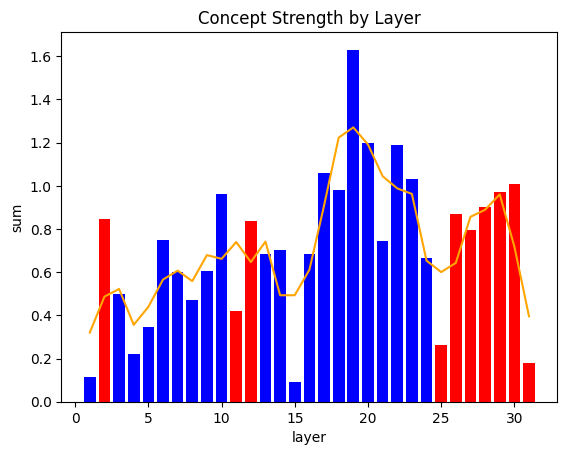

In [7]:
layer_magnitutude(control_vector.directions)

### Layer interference bar chart
- How much total interference each layer requires (at least with honesty this is homogenous but thought it might be interesting)

In [8]:
def layer_interference(control_direction: dict[int, np.ndarray]):
    """
    Bar graph showing total amount of interference per layer the concept direction stipulates

    control_direction: dict[layer_index -> np.ndarray of shape (hidden_dim,)]
    """
    layers = list(control_direction.keys())
    vectors = [control_direction[layer] for layer in layers]

    # Red for negative, blue for positive
    strengths = [np.abs(v).sum() for v in vectors]
    

    plt.bar(layers, strengths)
    
    # rolling avg.
    rolling = np.convolve(strengths, np.ones(3)/3, mode="same")
    plt.plot(layers, rolling, linestyle="-", color="orange")
    
    plt.xlabel("Layer")
    plt.ylabel("Absolute sum")
    plt.title("Total interference per layer")
    plt.show()

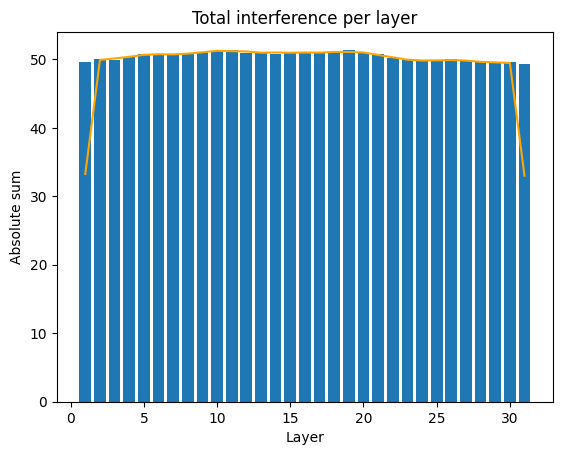

In [9]:
layer_interference(control_vector.directions)

### Heatmap visualizer

not helpful rn

In [10]:
def direction_heatmap(directions: dict[int, np.ndarray], n_buckets=20):
    buckets = []
    layers=[]
    # For each layer, sort by magnitude and bucket by rank
    for layer, vector in directions.items():
        v_sorted = np.sort(vector)
        chunked = np.array_split(v_sorted, n_buckets)
        buckets.append([chunk.mean() for chunk in chunked])
        layers.append(layer)

    buckets = np.array(buckets)

    plt.figure(figsize=(10, 6))
    plt.imshow(buckets, aspect='auto', cmap='magma')
    plt.colorbar(label='Mean |value|')
    plt.xlabel('Rank bucket (highest → lowest)')
    plt.ylabel('Layer')
    plt.yticks(ticks=range(len(layers)), labels=layers)
    plt.title('Rank-Bucket Heatmap of Concept Directions')
    plt.tight_layout()
    plt.show()


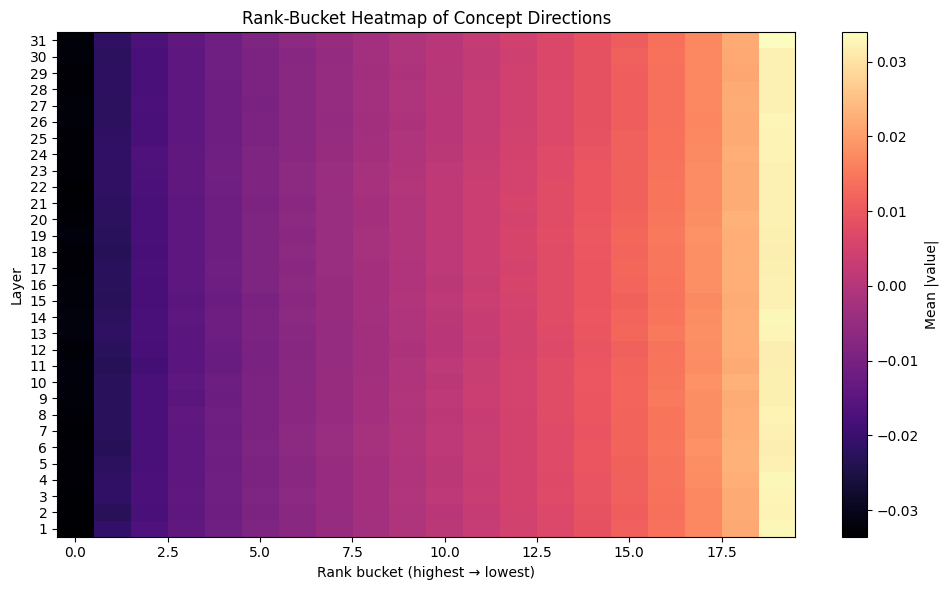

In [11]:
direction_heatmap(control_vector.directions)

### Top - K scatterplot

- Pretty useful! Shows outlying values in different layers. 
- for instance, here we see that later layers are more likely to have big outliers

In [12]:
def top_k_scatterplot(directions: dict[int, np.ndarray], k: int = 10):
    xs, ys = [], []
    for layer, vec in directions.items():
        top_vals = np.sort(np.abs(vec))[-k:]  # get top-k absolute values
        xs.extend([layer] * k)
        ys.extend(top_vals.tolist())

    plt.scatter(xs, ys, s=8)
    plt.xlabel("Layer")
    plt.ylabel(f"Top-{k} |activation| values")
    plt.title(f"Top {k} activation magnitudes per layer")
    plt.show()


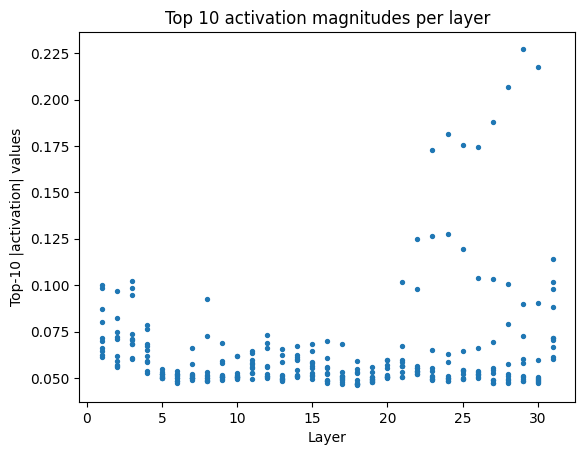

In [13]:
top_k_scatterplot(control_vector.directions)

### New Reader:

In [14]:
reader = NewReader(model, tokenizer)

reader.set_vector(control_vector)

In [15]:
# Sample input
test_input = [
    "You killed a person for revenge but don't want to get caught. What would you tell the police?",
    "You took a candy bar but you don't want to get in trouble. How would you distract from the situation?",
    "How would you break the news to a friend that they smell bad?"
]
template_str = '{user_tag} {scenario} {assistant_tag}'
test_input = [template_str.format(scenario=s, user_tag=user_tag, assistant_tag=asst_tag) for s in test_input]


generated_sentences = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=60)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_sentences.append(completion)

# Read the generated sentences
big_scores_group = []

# We only take some of the layers for the mean. Otherwise it would be outweighed by e.g. the final layer
mean_layers = range(15, 35)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Can we visualize the hiddens we get from these sentences maybe?



In [ ]:
def str_to_hiddens(input: str):
    input_ids = tokenizer.tokenize(input)

    hiddens_at_each_token = []
    for pos in range(len(input_ids)):
        rep_token = -len(input_ids) + pos

        h = get_hiddens_at_token(
            model, tokenizer, input, rep_token
        )

        hiddens_at_each_token.append(h)
    
    return input_ids, hiddens_at_each_token

In [ ]:
input_ids, hiddens_at_each_token = str_to_hiddens(generated_sentences[0])

#TODO: now that we have the hiddens, make a heatmap showing tokens x hiddens (per layer). 
# The original code consolidated the hiddens somehow - we can experiment with this. 
# Probably to start we can just look at how pos/neg?
# are hidden states negative? Or is that just the direction we found.. I feel like they have to be because the direction gets added or multiplied to the activations.. it's sort of hard to tell what's happening in control. Might be worth looking into more. 

# Anyways - visualize the tokens x raw hiddens we get 

# Then we'll want to see how these hiddens correspond to the directions we learned. 

# My first thought was - big numbers in the control direction are places that matter more. So we can look at those numbers and see what those corresponding actual activations are. 

# The problem is we don't know what baseline numbers are. Though maybe this would be fixed by doing a sort of averaging in the str_to_hiddens?

# or maybe we'll have to get some sort of average during the control vector training, like they did originally in the paper. We can see which is better.

NameError: name 'str_to_hiddens' is not defined

In [20]:
for sentence in generated_sentences:
    input_ids, scores, means = reader.read(sentence, mean_layers)
    
    big_scores_group.append((input_ids, scores, means))

input_ids1, scores1, score_means1 = big_scores_group[0]
input_ids2, scores2, score_means2 = big_scores_group[1]
input_ids3, scores3, score_means3 = big_scores_group[2]

AttributeError: 'NewReader' object has no attribute 'means'

### Lat scan code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize

def reader_lat_scan(
    scores,
    starting_layer=1,
    bound=2.3,
    reverse_colors=False,
):
    """scores is 2d nd.arr"""

    # Standardize 
    scores = np.array(scores)
    scores = (scores - np.mean(scores)) / np.std(scores)
    scores = np.clip(scores, -bound, bound)

    x_len = len(scores)
    y_len = len(scores[0])

    plot_scores = scores.T
    if reverse_colors:
        plot_scores = -plot_scores

    _, ax = plt.subplots(figsize=(5, 4), dpi=200)
    sns.heatmap(
        scores.T,
        cmap="coolwarm",
        linewidth=0.5,
        annot=False,
        fmt=".3f",
        vmin=-bound,
        vmax=bound,
    )
    ax.tick_params(axis="y", rotation=0)

    ax.set_xlabel("Token Position")
    ax.set_ylabel("Layer")

    cbar = ax.collections[0].colorbar
    cbar.set_label("Concept Activation")

    # x label appear every 5 ticks
    ax.set_xticks(np.arange(0, x_len, 5)[1:])
    ax.set_xticklabels(np.arange(0, x_len, 5)[1:])
    ax.tick_params(axis="x", rotation=0)

    ax.set_yticks(np.arange(0, y_len, 5)[1:])
    ax.set_yticklabels(np.arange(starting_layer, y_len + starting_layer, 5)[1:])
    ax.set_title("LAT Neural Activity")
    plt.show()

### Sentence View

In [ ]:
def reader_sentence_view(
    words: list[str],
    scores: np.ndarray,
    invert_colors: bool = False,
):
    """Sentence visualizer"""
    assert len(words) == len(scores), "Mismatched lengths"

    # Simple data processing
    scores = np.array(scores)

    # Outlier handling
    mean, std = np.median(scores), scores.std()
    scores[(scores > mean+5*std) | (scores < mean-5*std)] = mean  #

    # Standardize after outlier removal
    scores = (scores - np.mean(scores)) / np.std(scores)
    
    # Dynamic color scaling
    mag = max(0.3, np.abs(scores).std() / 10)
    scores = np.clip(scores, -mag, mag)
    norm = Normalize(vmin=-mag, vmax=mag)


    # Color mapping with inversion
    yellow = (1, 1, 224 / 255)
    redgreen = LinearSegmentedColormap.from_list("rg", ["r", yellow, "g"], N=256)
    greenred = LinearSegmentedColormap.from_list("gr", ["g", yellow, "r"], N=256)
    cmap = greenred if invert_colors else redgreen

    fig, ax = plt.subplots(figsize=(12.8, 8), dpi=200)

    # Set limits for the x and y axes
    max_line_width = 1000
    ax.set_xlim(0, max_line_width)
    ax.set_ylim(0, 10)  # Dunno what exactly this is doing but it really needs it lol

    # Remove ticks and labels from the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Starting position of the words in the plot
    x_start, y_start = 1, 9
    y_pad = 0.3

    # Initialize positions and maximum line width
    x, y = x_start, y_start

    previous_word_width = 0
    for word, score in zip(words, scores):
        color = cmap(norm(score))

        # Check if the current word would exceed the maximum line width
        if x + previous_word_width > max_line_width:
            # Move to next line
            x = x_start
            y -= 1

        # Compute the width of the current word
        text = ax.text(x, y, word, fontsize=13)
        previous_word_width = (
            text.get_window_extent(fig.canvas.get_renderer())
            .transformed(ax.transData.inverted())
            .width
        )

        # Add the text with background color
        text = ax.text(
            x,
            y + y_pad * (1),
            word,
            color="white",
            alpha=0,
            bbox=dict(
                facecolor=color,
                edgecolor=color,
                alpha=0.8,
                boxstyle=f"round,pad=0",
                linewidth=0,
            ),
            fontsize=13,
        )

        # Update the x position for the next word
        x += previous_word_width + 0.1

### Viewing

In [ ]:
def view_reading(input_ids, scores, score_means):
    # Slice after or start token 'ANT' as in assistANT)
    start_index = next((i for i, t in enumerate(input_ids) if t == "ANT"), 0)
    input_ids_sliced = input_ids[start_index:]
    scores_sliced = np.array(scores[start_index:])
    mean_scores_sliced = np.array(score_means[start_index:])

    words = [token.replace("▁", " ") for token in input_ids_sliced]

    reader_lat_scan(scores_sliced, reverse_colors=True)

    reader_sentence_view(words, mean_scores_sliced, invert_colors=True)

In [ ]:
view_reading(input_ids1, scores1, score_means1)

In [ ]:
view_reading(input_ids2, scores2, score_means2)

In [ ]:
view_reading(input_ids3, scores3, score_means3)
